Create a model for the mutual impedance matrix of an array of parallel dipole antenna elements. Choose from the following options for the model:

 Commercial software package: If you have access to software like HFSS, EMPIRE, studentversion of FEKO, NEC, or any other similar package, use the commercial package to find the mutual impedance matrix and open circuit loaded embedded element patterns for the dipole array.

 I am goint to use HFSS

Problem 4.8

Write a script to find the directivity of a 4 element ULA of isotropic radiators using the overlap integral. Plot the broadside directivity as a function of element spacing over the range $0 \leq d \leq 3\lambda$. 

Overlay the directivity obtained with the conjugate field match solution.

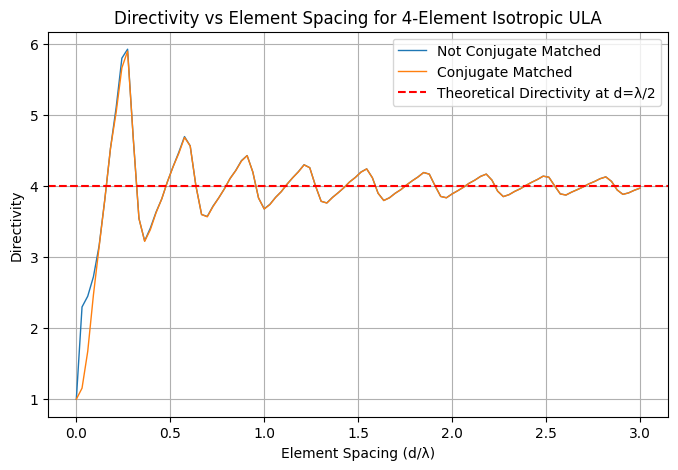

In [18]:
#FOLLOWING THE STEPS OUTLINE IN SECTION 4.14.1 APPLYING THE LOSSLESS RESONANT MINIMUM SCATTERING APPROXIMATION
#EACH ELEMENT IS A HALF-WAVE DIPOLE

########### IMPORTS #############
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi



###################################################################### DEFINITIONS ########################################################

# use the isotropic radiation pattern on page 
def radiation_pattern(eta, k, Prad, r):
    #print("radiation integral\n", np.sqrt(2*eta*Prad/(4*np.pi*r**2)) * np.exp(1j*k*r)) # debug radiation pattern
    return np.sqrt(2*eta*Prad/(4*np.pi*r**2)) * np.exp(1j*k*r)
     
# phase shift the radiation pattern by the distance between the elements
def phase_shifted(phase_shift, theta, f):
    lam = 3e8 / f       # Wavelength in m
    k = 2*np.pi / lam   # Wave number
    l = lam / 2         # Half-wave dipole length
    #print("phase shifted \n", np.abs(np.exp(1j * k * phase_shift * np.cos(theta)) * radiation_pattern(theta, k, l)))   # debug phase shifted
    return np.abs(np.exp(1j * k * phase_shift * np.cos(theta)) * radiation_pattern(theta, k, l))

# integrand for the overlap integral outling in section 4.8.3
def integrand(theta, phi, rx_m, rx_n, f):
    # print("integrand")  # debug integrand                                       
    # print(np.sin(theta))                    
    # print(phase_shifted(rx_m, theta, f))
    # print(phase_shifted(rx_m, theta, f))
    # print(phase_shifted(rx_m, theta, f) * phase_shifted(rx_n, phi, f) * np.sin(theta))
    return phase_shifted(rx_m, theta, f) * phase_shifted(rx_n, phi, f) * np.sin(theta)

# compute the overlap integral as outlined in section 4.8.3
def overlap_integral(N, rx):
    A = np.zeros((N, N))                # initialize the overlap matrix
    for m in range(N):
        for n in range(N):
            r_mn = rx[m] - rx[n]        # distance between elements
            A[m, n] = np.sinc(k*r_mn)   # assign the value of the integral to the overlap matrix
    #print("Overlap Matrix \n", A)      # debug overlap matrix                                  
    return A

# scale the the overlap integral using equation 4.108
def mutual_impedance_matrix(Im, N, rx):
    Zo = 50
    #scalar = np.sqrt(2*eta*Prad/(4*np.pi*r**2)) # Amplitude of the E-Field of an isotropic radiator
    #scalar = np.sqrt(eta*Zo/4*np.pi) * Im/r
    #scalar = 2/np.abs(Im)**2                   # Equation 4.108
    #scalar = 50                                # impedance of an isotropic radiator
    scalar = 4                                 # baseline scalar

    Z = scalar * overlap_integral(N, rx) # mutual impedance matrix
    #print("Mutual Impedance Matrix \n", Z)
    return Z



########################################### VARIABLES ############################################
# Define antenna parameters
f = 1e9                 # Frequency in Hz
c = 3e8                 # Speed of light in m/s
lam = c / f             # Wavelength in m
k = 2 * np.pi / lam     # Wave number
eta = 377               # Intrinsic impedance of free space
Prad = 1                 # Radiated power
r = 1                   # Observation distance
l = lam / 2             # Half-wave dipole length
Im = 1                  # Mutual impedance
psi = np.pi/2           # broadside or endfire

# Define element spacing range
num_points = 100
d_values = np.linspace(0, 3*lam, num_points)  # Range of element spacings

# Number of elements in the array
N = 4

# empty array of directivity values
directivity_values = []
directivity_values_cm = []




################################################## MAIN ##########################################################
for d in d_values:
    ## Define the receiver positions ##
    rx = np.array([n * d for n in range(N)])    # Positions of elements

    ## compute Ep ##
    Ep = np.zeros((N, 1), dtype=complex)        # Initialize electric field
    #scalar = 1j * Im / (2 * np.pi * r)         # Amplitude of the E-Field of a dipole on page 84
    scalar = 2/np.abs(Im)**2                    # Equation 4.108
    #scalar = 73.5                              # impedance of a half wave dipole

    # Ep loop for broadside
    for n in range(N):
        Ep[n] = scalar*radiation_pattern(eta, k, Prad, r)*np.exp(1j*k*d*np.cos(psi)*rx[n]) # Compute electric field
    #print("Ep \n", Ep)                         # debug e-field

    ## Compute weights ##
    A = mutual_impedance_matrix(Im, N, rx)   # compute mutual impedance matrix
    A_inv = np.linalg.pinv(A)                   # invert overlap
    w = np.dot(A_inv, Ep)                       # Compute weights equation 4.86
    #print("weights \n", w)                     # debug weights
    w_cm = Ep                                   # Conjugate matched weights

    ## compute signal response ##
    B = Ep*Ep.conj().T / (2*eta)    # Compute signal response equation 4.66
    
    ## Compute Directivity using equation 4.63 ##
    w_herm = w.conj().T                         # Compute hermitian of weights
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    scalar = 4 * np.pi * (r**2) / Prad           # Compute directivity scalar
    wB = np.dot(w_herm, B)
    numerator = np.dot(wB, w)
    wA = np.dot(w_herm, A)
    denominator = np.dot(wA, w)
    D = scalar * numerator / denominator        # Compute directivity equation 4.63
    #print("Directivity \n", D)                 # debug directivity

    ## Compute Conjugate Matched Directivity ##
    w_herm = w_cm.conj().T
    #print("hermitian of weights \n", w_herm)
    wB = np.dot(w_herm, B)
    numerator = np.dot(wB, w_cm)
    wA = np.dot(w_herm, A)
    denominator = np.dot(wA, w_cm)
    D_cm = scalar * numerator / denominator         # Compute directivity equation 4.63
    #print("Directivity \n", D_cm)                  # debug directivity

    # append zeros
    directivity_values.append(D[0,0])
    directivity_values_cm.append(D_cm[0,0])

# equation 4.90 used as a target directivity
Del = 1              # directivity of a half-wave dipole
d_theoretical = N * Del # theoretical directivity of the array


####################################################### PLOTS ###########################################################
plt.figure(figsize=(8, 5))
plt.plot(d_values / lam, directivity_values, label="Not Conjugate Matched", linewidth=1)
plt.plot(d_values / lam, directivity_values_cm, label="Conjugate Matched", linewidth=1)
plt.axhline(y=d_theoretical, color='r', linestyle='--', label="Theoretical Directivity at d=λ/2")  # Reference line
plt.xlabel("Element Spacing (d/λ)")
plt.ylabel("Directivity")
plt.title("Directivity vs Element Spacing for 4-Element Isotropic ULA")
plt.grid(True)
plt.legend()
plt.show() 

C:\Users\tw443\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tw443\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


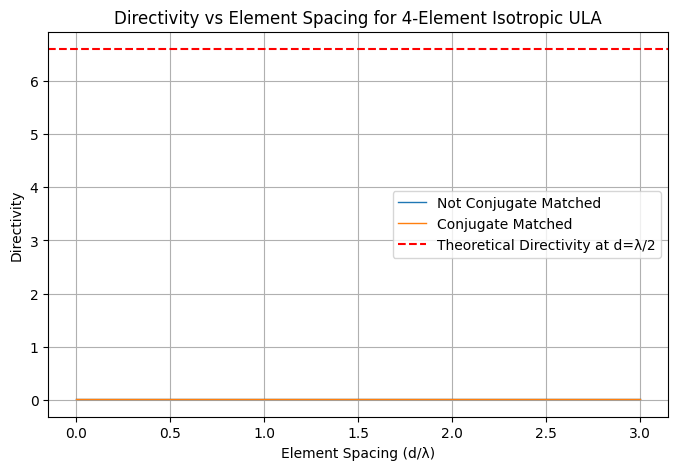

In [23]:
#FOLLOWING THE STEPS OUTLINE IN SECTION 4.14.1 APPLYING THE LOSSLESS RESONANT MINIMUM SCATTERING APPROXIMATION
#EACH ELEMENT IS A HALF-WAVE DIPOLE

########### IMPORTS #############
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi



###################################################################### DEFINITIONS ########################################################

# use the half-wave dipole radiation pattern on page 84
def radiation_pattern(theta, k, l):
    #print("radiation integral\n", (np.cos(k*l*np.cos(theta)/2)-np.cos(k*l/2)) / np.sin(theta)) # debug radiation pattern
    return np.abs((np.cos(k*l*np.cos(theta)/2)-np.cos(k*l/2)) / np.sin(theta))
     
# phase shift the radiation pattern by the distance between the elements
def phase_shifted(phase_shift, theta, phi, f):
    lam = 3e8 / f       # Wavelength in m
    k = 2*np.pi / lam   # Wave number
    l = lam / 2         # Half-wave dipole length
    #print("phase shifted \n", np.abs(np.exp(1j * k * phase_shift * np.cos(theta)) * radiation_pattern(theta, k, l)))   # debug phase shifted
    return np.abs(np.exp(1j * k * phase_shift * np.cos(phi) * np.sin(theta)) * radiation_pattern(theta, k, l))

# integrand for the overlap integral outling in section 4.8.3
def integrand(theta, phi, rx_m, rx_n, f):
    # print("integrand")  # debug integrand                                       
    # print(np.sin(theta))                    
    # print(phase_shifted(rx_m, theta, f))
    # print(phase_shifted(rx_m, theta, f))
    # print(phase_shifted(rx_m, theta, f) * phase_shifted(rx_n, phi, f) * np.sin(theta))
    return phase_shifted(rx_m, theta, phi, f) * phase_shifted(rx_n, theta, phi, f) * np.sin(theta)

# compute the overlap integral as outlined in section 4.8.3
def overlap_integral(N, f, rx):
    A = np.zeros((N, N))
    points = 100                                                                    # initialize the overlap matrix
    for m in range(N):
        for n in range(N):
            #I, _ = spi.quad(lambda theta: integrand(theta, rx[m], rx[n], f), 0, np.pi)     # python function to implement the quadrature rule

            # numerical implementation of the quadrature rule according to equations 4.69 and 4.70
            I = 0                                                                           # initialize the integral
            del_phi = 2*np.pi/points                                                             # integration weights
            del_theta = del_phi/2                                                            # integration weights
            for i in range(points):
                phi_i = (i - 1/2) * del_phi                                                 # midpoint for each integration step
                for j in range(int(points/2)):
                    theta_j = (j - 1/2) * del_theta                                         # midpoint for each integration step
                    I += integrand(theta_j, phi_i, rx[m], rx[n], f) * del_phi * del_theta   # integral approximation
                    # print("I\n", I)                                                         # debug integral                     
            #print("I \n", I)                                                               # debug integral                                 

            A[m, n] = I                                                                     # assign the value of the integral to the overlap matrix

    #print("Overlap Matrix \n", A)                                                          # debug overlap matrix                                  
    return A

# scale the the overlap integral using equation 4.108
def mutual_impedance_matrix(Im, N, f, rx):
    #scalar = 1j*Im/(2*np.pi*r)             # Amplitude of the E-Field of a dipole on page 84
    scalar = 2/np.abs(Im)**2                # Equation 4.108
    #scalar = 73.5                          # impedance of a half wave dipole

    Z = scalar * overlap_integral(N, f, rx) # mutual impedance matrix
    #print("Mutual Impedance Matrix \n", Z)
    return Z



########################################### VARIABLES ############################################
# Define antenna parameters
f = 1e9                 # Frequency in Hz
c = 3e8                 # Speed of light in m/s
lam = c / f             # Wavelength in m
k = 2 * np.pi / lam     # Wave number
eta = 377               # Intrinsic impedance of free space
Pel = 1                 # Radiated power
r = 1                   # Observation distance
l = lam / 2             # Half-wave dipole length
Im = 1                  # Mutual impedance
psi = np.pi/2           # broadside or endfire

# Define element spacing range
num_points = 100
d_values = np.linspace(0, 3*lam, num_points)  # Range of element spacings

# Number of elements in the array
N = 4

# empty array of directivity values
directivity_values = []
directivity_values_cm = []




################################################## MAIN ##########################################################
for d in d_values:
    ## Define the receiver positions ##
    rx = np.array([n * d for n in range(N)])    # Positions of elements

    ## compute Ep ##
    Ep = np.zeros((N, 1), dtype=complex)        # Initialize electric field
    #scalar = 1j * Im / (2 * np.pi * r)         # Amplitude of the E-Field of a dipole on page 84
    scalar = 2/np.abs(Im)**2                    # Equation 4.108
    #scalar = 73.5                              # impedance of a half wave dipole

    # Ep loop for broadside
    for n in range(N):
        Ep[n] = scalar*radiation_pattern(psi, k, l)*np.exp(1j*k*d*np.cos(psi)*rx[n]) # Compute electric field
    #print("Ep \n", Ep)                         # debug e-field

    ## Compute weights ##
    A = mutual_impedance_matrix(Im, N, f, rx)   # compute mutual impedance matrix
    A_inv = np.linalg.pinv(A)                   # invert overlap
    w = np.dot(A_inv, Ep)                       # Compute weights equation 4.86
    #print("weights \n", w)                     # debug weights
    w_cm = Ep                                   # Conjugate matched weights

    ## compute signal response ##
    B = Ep*Ep.conj().T / (2*eta)    # Compute signal response equation 4.66
    
    ## Compute Directivity using equation 4.63 ##
    w_herm = w.conj().T                         # Compute hermitian of weights
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    scalar = 4 * np.pi * (r**2) / Pel           # Compute directivity scalar
    wB = np.dot(w_herm, B)
    numerator = np.dot(wB, w)
    wA = np.dot(w_herm, A)
    denominator = np.dot(wA, w)
    D = scalar * numerator / denominator        # Compute directivity equation 4.63
    #print("Directivity \n", D)                 # debug directivity

    ## Compute Conjugate Matched Directivity ##
    w_herm = w_cm.conj().T
    #print("hermitian of weights \n", w_herm)
    wB = np.dot(w_herm, B)
    numerator = np.dot(wB, w_cm)
    wA = np.dot(w_herm, A)
    denominator = np.dot(wA, w_cm)
    D_cm = scalar * numerator / denominator         # Compute directivity equation 4.63
    #print("Directivity \n", D_cm)                  # debug directivity

    # append zeros
    directivity_values.append(D[0,0])
    directivity_values_cm.append(D_cm[0,0])

# equation 4.90 used as a target directivity
Del = 1.65              # directivity of a half-wave dipole
d_theoretical = N * Del # theoretical directivity of the array


####################################################### PLOTS ###########################################################
plt.figure(figsize=(8, 5))
plt.plot(d_values / lam, directivity_values, label="Not Conjugate Matched", linewidth=1)
plt.plot(d_values / lam, directivity_values_cm, label="Conjugate Matched", linewidth=1)
plt.axhline(y=d_theoretical, color='r', linestyle='--', label="Theoretical Directivity at d=λ/2")  # Reference line
plt.xlabel("Element Spacing (d/λ)")
plt.ylabel("Directivity")
plt.title("Directivity vs Element Spacing for 4-Element Isotropic ULA")
plt.grid(True)
plt.legend()
plt.show() 